In [1]:
pip install uproot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.7/375.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.1/886.1 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 638.7/638.7 kB 15.6 MB/s eta 0:00:00


In [2]:
from google.colab import files
uploaded = files.upload()

Saving output_histograms.root to output_histograms.root


In [3]:
import uproot
import numpy as np
import pandas as pd

#-------------------------------
# SETTINGS
#-------------------------------
n_samples = 100000
luminosity_fb = 100.0  # Target luminosity

# Cross sections (pb)
signal_cross_section_pb = 0.02142500
background_cross_sections_pb = {
    "aa_ww": 0.0150743,
    "aa_ttbar": 4.824851e-03 / 100.0,
    "aa_tautau": 2.51510000,
    "aa_mumu": 2.57270000,
    "inclusive_ttbar": 0.0065764,
    "single_top": 1.36209,
    "w_production": 1.910288,
    "z_production": 0.24064758729900002,
    "wwj": 0.016080595320336195,
    "zzj": 6.694889944457796e-03 / 100.0,
    "wzj": 0.0023785292894910495
}

# Histogram names
observable_map = {
    "lepton_pt": "hist_lepton_pt",
    "lepton_eta": "hist_lepton_eta",
    "leading_jet_pt": "hist_leading_jet_pt",
    "leading_jet_eta": "hist_leading_jet_eta",
    "subleading_jet_eta": "hist_subleading_jet_eta",
    "missing_et": "hist_missing_et",
    "delta_r": "hist_delta_r",
    "jet_centrality": "hist_jet_centrality",
    "delta_eta_jj": "hist_delta_eta_jj",
    "m_w_hadronic": "hist_m_w_hadronic",
    "m_w_leptonic": "hist_m_w_leptonic"
}

special_suffix = {"wwj", "zzj", "wzj"}
background_keys = list(background_cross_sections_pb.keys())

#-------------------------------
# FUNCTIONS
#-------------------------------
def sample_from_hist(hist, n):
    """
    Given an uproot.TH1 object `hist`, sample `n` values according to its bin contents.
    This mimics drawing n_samples from the histogram by expanding each bin's count
    into uniformly distributed points within that bin, then sampling with replacement.
    """
    values_list = []
    # Extract bin contents and edges from uproot hist
    bin_contents = hist.values()   # array of length nbins
    # Access bin edges using the axis() method and call .edges() to get the array
    bin_edges = hist.axis().edges()       # array of length nbins+1

    # Iterate over each bin
    for i, count in enumerate(bin_contents):
        count_int = int(count)
        if count_int > 0:
            xlow = bin_edges[i]
            xhigh = bin_edges[i + 1]
            # Generate `count_int` uniform samples in [xlow, xhigh)
            values_list.extend(np.random.uniform(xlow, xhigh, size=count_int))

    if len(values_list) == 0:
        # If no entries in the histogram, return an array of NaNs
        return np.full(n, np.nan)

    # Sample exactly n values from the expanded list with replacement
    return np.random.choice(values_list, size=n, replace=True)

#-------------------------------
# PROCESS SIGNAL
#-------------------------------
# Open the ROOT file with uproot
file = uproot.open("output_histograms.root")

signal_data = {}
for obs, hist_base in observable_map.items():
    full_hist_name = f"{hist_base}_FM2_Lambda4"
    root_path = f"signal_FM2_Lambda4/{full_hist_name}"

    try:
        # Retrieve the TH1 object from the file
        hist = file[root_path]
        # Sample n_samples points from this histogram
        signal_data[obs] = sample_from_hist(hist, n_samples)
    except KeyError:
        # If the histogram key doesn't exist, fill with NaNs and print a warning
        print(f"❌ Missing: {full_hist_name} in signal")
        signal_data[obs] = np.full(n_samples, np.nan)

# Build a DataFrame for signal
signal_df = pd.DataFrame(signal_data)
signal_df["label"] = 1
signal_df["weight"] = signal_cross_section_pb * luminosity_fb * 1000.0
signal_df["process"] = "FM2_Lambda4"

#-------------------------------
# PROCESS BACKGROUNDS
#-------------------------------
background_dataframes = []
for bkg in background_keys:
    bkg_data = {}
    suffix = "_production" if bkg in special_suffix else ""
    for obs, hist_base in observable_map.items():
        full_hist_name = f"{hist_base}_{bkg}{suffix}"
        root_path = f"background_{bkg}/{full_hist_name}"

        try:
            hist = file[root_path]
            bkg_data[obs] = sample_from_hist(hist, n_samples)
        except KeyError:
            print(f"⚠️ Missing: {full_hist_name} in {bkg}")
            bkg_data[obs] = np.full(n_samples, np.nan)

    df_bkg = pd.DataFrame(bkg_data)
    df_bkg["label"] = 0
    df_bkg["weight"] = background_cross_sections_pb[bkg] * luminosity_fb * 1000.0
    df_bkg["process"] = bkg
    background_dataframes.append(df_bkg)

#-------------------------------
# MERGE, CLEAN, SAVE
#-------------------------------
background_df = pd.concat(background_dataframes, ignore_index=True)
full_df = pd.concat([signal_df, background_df], ignore_index=True)
full_df.dropna(inplace=True)

# Save to CSV
full_df.to_csv("ml_input_from_histograms.csv", index=False)
print(f"✅ Saved: ml_input_from_histograms.csv with {full_df.shape[0]} events and weights for {luminosity_fb:.1f} fb^-1.")

✅ Saved: ml_input_from_histograms.csv with 1000000 events and weights for 100.0 fb^-1.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:05:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


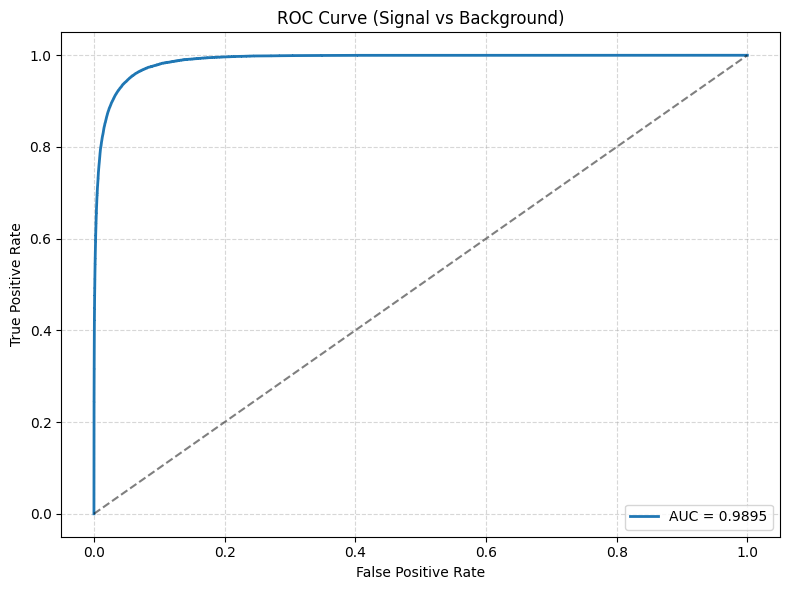

<Figure size 1000x600 with 0 Axes>

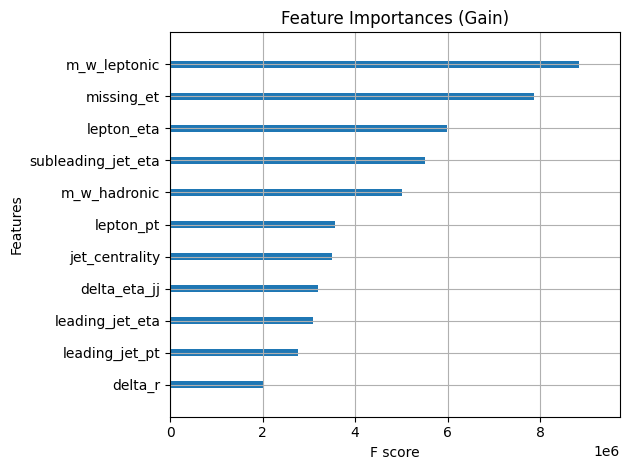

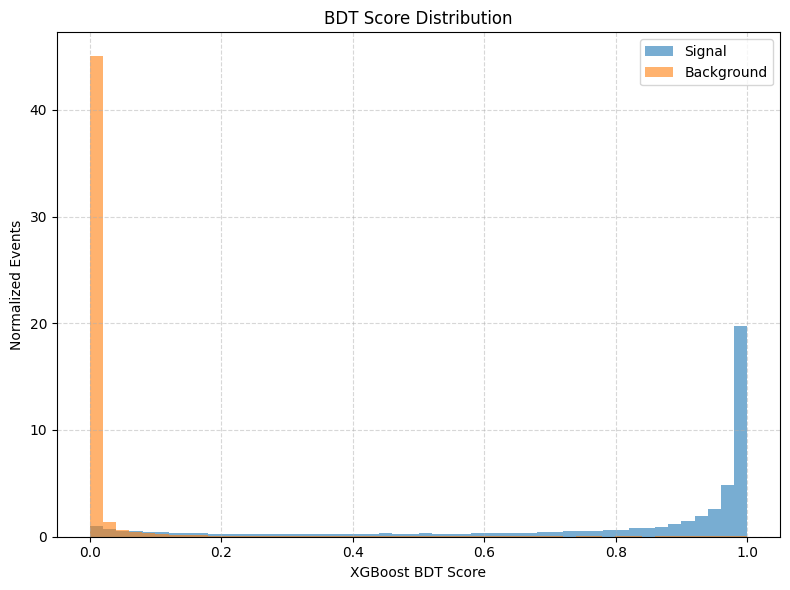

In [4]:
#import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

# Load dataset
df = pd.read_csv("ml_input_from_histograms.csv")
X = df.drop(columns=["label", "weight", "process"])

y = df["label"]
weights = df["weight"]

# Split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.25, stratify=y, random_state=42
)

# Train XGBoost with weights
model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    use_label_encoder=False,
    eval_metric="logloss"
)
model.fit(X_train, y_train, sample_weight=w_train)


# Predict probabilities
y_scores = model.predict_proba(X_test)[:, 1]

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Signal vs Background)")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("roc_curve_xgboost.pdf")
plt.show()

# Feature importances
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, importance_type="gain", show_values=False)
plt.title("Feature Importances (Gain)")
plt.tight_layout()
plt.savefig("feature_importances_xgboost.pdf")
plt.show()

# BDT score distribution
plt.figure(figsize=(8, 6))
plt.hist(y_scores[y_test == 1], bins=50, alpha=0.6, label="Signal", density=True)
plt.hist(y_scores[y_test == 0], bins=50, alpha=0.6, label="Background", density=True)
plt.xlabel("XGBoost BDT Score")
plt.ylabel("Normalized Events")
plt.title("BDT Score Distribution")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("bdt_score_distribution.pdf")
plt.show()

In [ ]:
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import uproot  # Replace ROOT with uproot
"""

#-------------------------
# Settings
#-------------------------
n_generated = 1_000_000
luminosity_fb = 100.0
signal_cross_section_pb = 0.02142500  # [pb]

# Cross sections (pb) for backgrounds
background_cross_sections_pb = {
    "aa_ww": 0.0150743,
    "aa_ttbar": 4.824851e-03 / 100.0,
    "aa_tautau": 2.51510000,
    "aa_mumu": 2.57270000,
    "inclusive_ttbar": 0.0065764,
    "single_top": 1.36209,
    "w_production": 1.910288,
    "z_production": 0.24064758729900002,
    "wwj": 0.016080595320336195,
    "zzj": 6.694889944457796e-03 / 100.0,
    "wzj": 0.0023785292894910495
}

#-------------------------
# Load ML dataset
#-------------------------
df = pd.read_csv("ml_input_from_histograms.csv")
has_process = "process" in df.columns

X = df.drop(columns=["label", "weight"] + (["process"] if has_process else []))
y = df["label"]
weights = df["weight"]

#-------------------------
# Train BDT
#-------------------------
model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    use_label_encoder=False,
    eval_metric="logloss"
)
model.fit(X, y, sample_weight=weights)
df["bdt_score"] = model.predict_proba(X)[:, 1]

#-------------------------
# Optimal threshold
#-------------------------
thresholds = np.linspace(0.0, 1.0, 100)
best_threshold = max(
    thresholds,
    key=lambda t: df[df["bdt_score"] > t].query("label == 1")["weight"].sum()
    / np.sqrt(df[df["bdt_score"] > t]["weight"].sum() + 1e-9)
)
df_cut = df[df["bdt_score"] > best_threshold]

#-------------------------
# Signal stats
#-------------------------
s_total = df[df["label"] == 1]["weight"].sum()
s_after = df_cut[df_cut["label"] == 1]["weight"].sum()
efficiency_bdt = s_after / s_total if s_total > 0 else 0.0

# Signal preselection efficiency - UPROOT VERSION
with uproot.open("output_histograms.root") as f:  # Use context manager
    # Get signal histogram
    hist_path = "signal_FM2_Lambda4/hist_jet_centrality_FM2_Lambda4"
    if hist_path in f:  # Check if histogram exists
        hist_preselected_sig = f[hist_path]
        n_preselected_sig = hist_preselected_sig.values(flow=True).sum()  # Include underflow/overflow
    else:
        n_preselected_sig = 0

eff_preselection_sig = n_preselected_sig / n_generated
eff_total_sig = eff_preselection_sig * efficiency_bdt

#-------------------------
# Background stats
#-------------------------
df_bkg = df[df["label"] == 0].copy()
df_bkg_cut = df_cut[df_cut["label"] == 0].copy()
if has_process:
    df_bkg["process"] = df["process"]
    df_bkg_cut["process"] = df_cut["process"]
else:
    df_bkg["process"] = "Unknown"
    df_bkg_cut["process"] = "Unknown"

b_total = df_bkg_cut["weight"].sum()
bkg_cutflow = df_bkg_cut.groupby("process")["weight"].sum().sort_values(ascending=False)

# MC background efficiency (total)
eff_bkg_total = df_bkg_cut.shape[0] / df_bkg.shape[0]

#-------------------------
# Background efficiencies and yields by process - UPROOT VERSION
#-------------------------
print("\n🧾 Background efficiencies and projected yields (100 fb⁻¹):")
total_yield_manual = 0

with uproot.open("output_histograms.root") as f:  # Reuse context manager
    for proc in df_bkg["process"].unique():
        suffix = "_production" if proc in {"wwj", "zzj", "wzj"} else ""
        hist_name = f"hist_jet_centrality_{proc}{suffix}"
        full_path = f"background_{proc}/{hist_name}"

        # Get background histogram
        if full_path in f:
            proc_hist = f[full_path]
            n_pre_bkg = proc_hist.values(flow=True).sum()  # Include underflow/overflow
        else:
            n_pre_bkg = 0

        n_cut_bkg = df_bkg_cut[df_bkg_cut["process"] == proc].shape[0]
        eff_pre_bkg = n_pre_bkg / n_generated
        eff_bdt_bkg = n_cut_bkg / n_pre_bkg if n_pre_bkg > 0 else 0.0
        eff_total_bkg = eff_pre_bkg * eff_bdt_bkg
        xs = background_cross_sections_pb.get(proc, 0.0)
        expected_yield = eff_total_bkg * xs * luminosity_fb * 1000.0
        total_yield_manual += expected_yield
        print(f"  {proc:<16}  pre: {eff_pre_bkg:.4f},  BDT: {eff_bdt_bkg:.4f},  total: {eff_total_bkg:.4f},  yield: {expected_yield:.2f}")

#-------------------------
# Report
#-------------------------
print(f"\n💎 Optimal BDT cut: {best_threshold:.3f}")
print(f"🧬 BDT efficiency (from preselected): {efficiency_bdt:.4f}")
print(f"🧬 Preselection efficiency (from ROOT): {eff_preselection_sig:.4f} ({int(n_preselected_sig)} / {n_generated})")
print(f"🧬 Total signal efficiency (MC from 1M): {eff_total_sig:.4f}")
print(f"🎭 MC background efficiency (from all samples): {eff_bkg_total:.4f}")
print(f"📈 Significance Z = S / √(S+B): {s_after / np.sqrt(s_after + b_total):.2f}")
print(f"🎯 Total background after cut: {b_total:.2f} (weighted sum)")
print(f"📊 Total background yield from per-process calculation: {total_yield_manual:.2f}")
print("\n📊 Background yields by process (from DataFrame sum):")
print(bkg_cutflow.to_string())

#-------------------------
# Save filtered events
#-------------------------
df_cut[df_cut["label"] == 1].to_csv("signal_after_cut.csv", index=False)
df_cut[df_cut["label"] == 0].to_csv("background_after_cut.csv", index=False)

#-------------------------
# Plot BDT score
#-------------------------
plt.figure(figsize=(8, 6))
plt.hist(df[df["label"] == 1]["bdt_score"], bins=50, alpha=0.5, label="Signal", density=True)
plt.hist(df[df["label"] == 0]["bdt_score"], bins=50, alpha=0.5, label="Background", density=True)
plt.axvline(best_threshold, color='red', linestyle='--', label=f"Cut = {best_threshold:.3f}")
plt.xlabel("BDT Score")
plt.ylabel("Normalized Entries")
plt.title("BDT Score with Optimal Cut")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("bdt_cut_applied.pdf")
plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:06:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


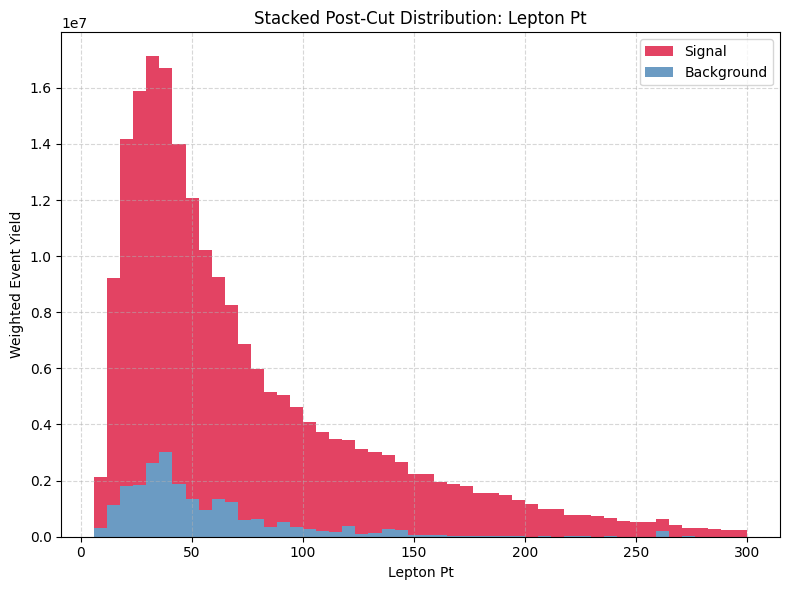

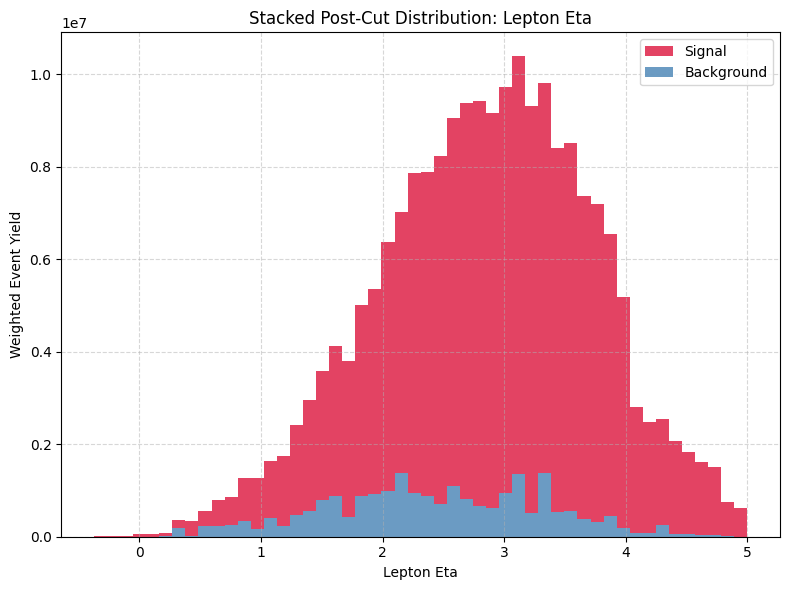

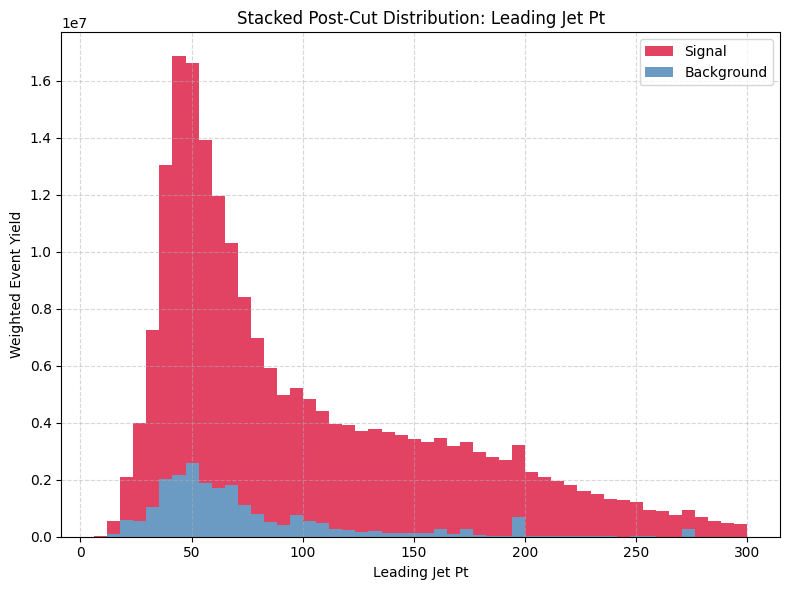

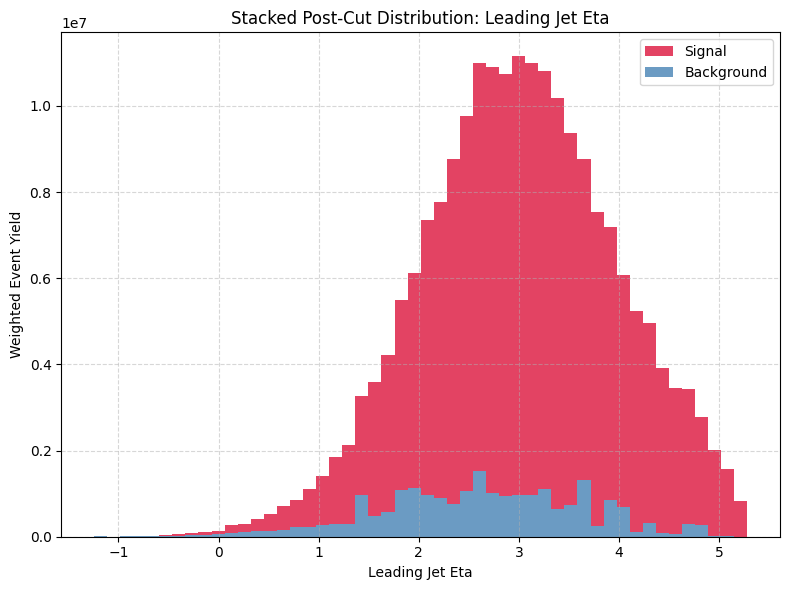

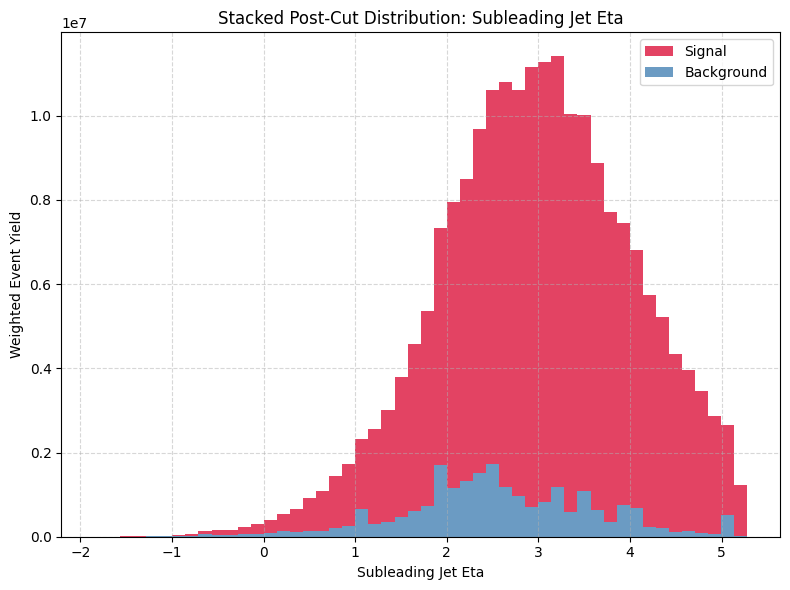

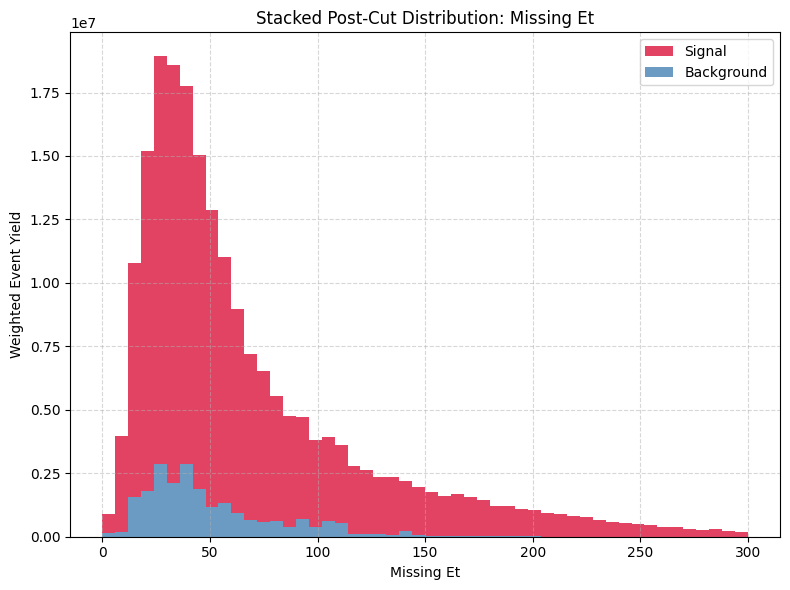

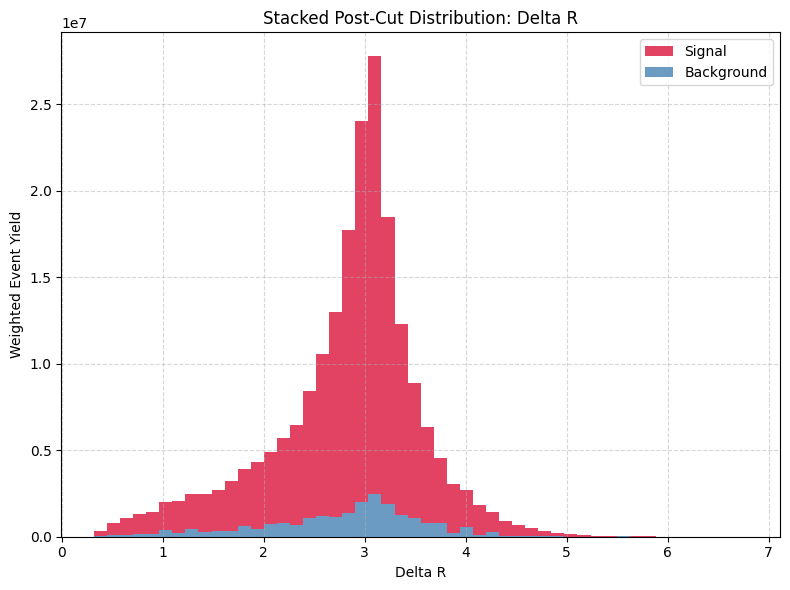

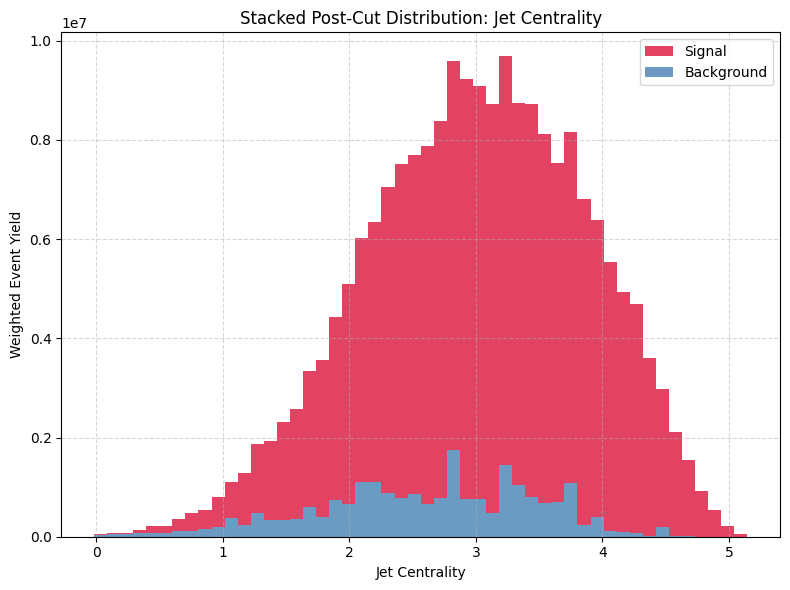

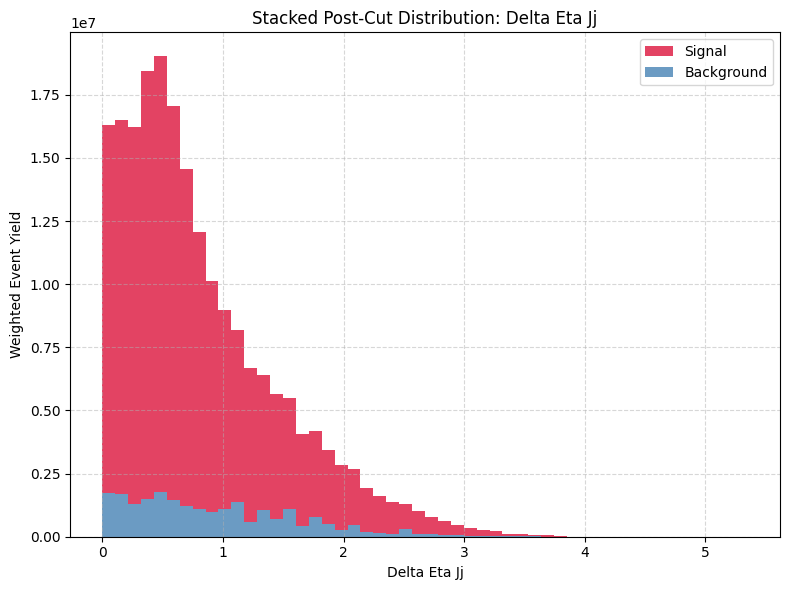

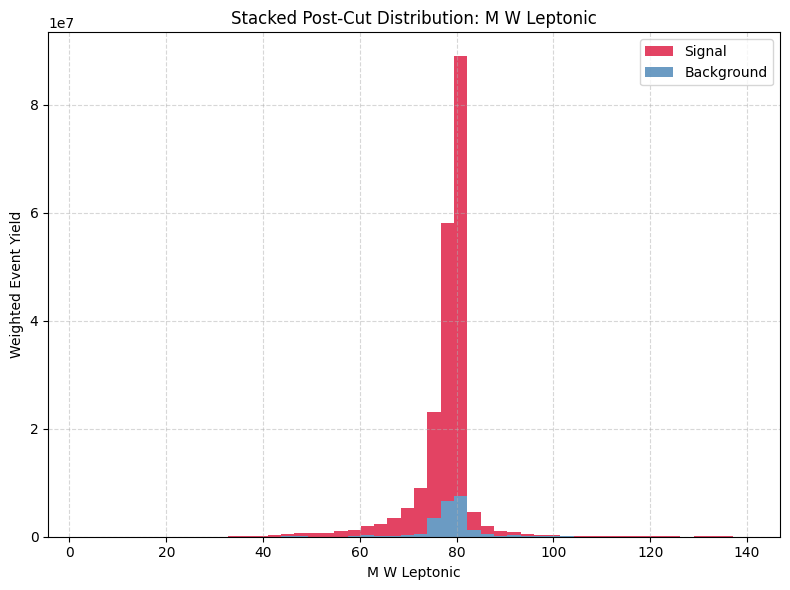

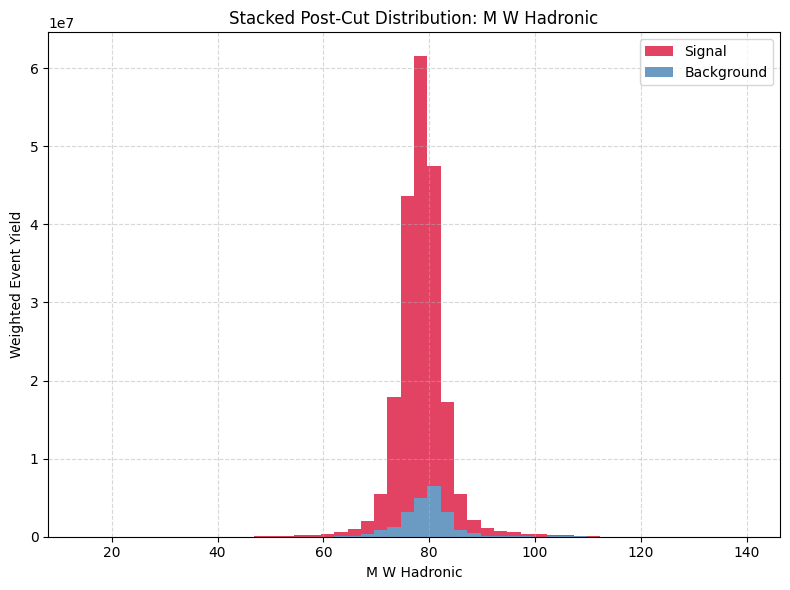

✅ All stacked post-cut distributions saved as PDF and displayed inline.


In [7]:
#import pandas as pd
#import numpy as np
#import matplotlib.pyplot as plt

# Load post-cut data
signal_df = pd.read_csv("signal_after_cut.csv")
background_df = pd.read_csv("background_after_cut.csv")

# Features to compare
features = [
    "lepton_pt", "lepton_eta",
    "leading_jet_pt", "leading_jet_eta", "subleading_jet_eta",
    "missing_et", "delta_r", "jet_centrality", "delta_eta_jj",
    "m_w_leptonic", "m_w_hadronic"
]

# Plot for each feature
for feature in features:
    plt.figure(figsize=(8, 6))

    # Define binning based on the combined range
    min_val = min(signal_df[feature].min(), background_df[feature].min())
    max_val = max(signal_df[feature].max(), background_df[feature].max())
    bins = 50
    bin_edges = np.linspace(min_val, max_val, bins + 1)

    # Histogram values
    sig_vals, _ = np.histogram(signal_df[feature], bins=bin_edges, weights=signal_df["weight"])
    bkg_vals, _ = np.histogram(background_df[feature], bins=bin_edges, weights=background_df["weight"])

    # Stack bars
    plt.hist(
        [bin_edges[:-1], bin_edges[:-1]],
        bins=bin_edges,
        weights=[bkg_vals, sig_vals],
        label=["Background", "Signal"],
        stacked=True,
        color=["steelblue", "crimson"],
        histtype='stepfilled',
        alpha=0.8
    )

    plt.xlabel(feature.replace("_", " ").title())
    plt.ylabel("Weighted Event Yield")
    plt.title(f"Stacked Post-Cut Distribution: {feature.replace('_', ' ').title()}")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()

    # Save the figure as a PDF
    plt.savefig(f"post_cut_{feature}_stacked.pdf")
    # Show it inline in Colab
    plt.show()
    # Close to free memory
    plt.close()

print("✅ All stacked post-cut distributions saved as PDF and displayed inline.")